In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from typing import List
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Đọc toàn bộ dữ liệu

Chuyển dữ liệu năm sản xuất sang tuổi xe

In [2]:
dataset = pd.read_pickle('data/train/cars.pkl')
dataset["Năm sản xuất"] = 2024 - dataset["Năm sản xuất"]
dataset.rename(columns={"Năm sản xuất": "Tuối xe"}, inplace=True)
print(dataset.shape)
dataset.head()

(25582, 15)


,Tên hãng xe,Tuối xe,Tỉnh,Số Km đã đi,Xuất xứ,Kiểu dáng,Hộp số,Màu ngoại thất,Màu nội thất,Số chỗ ngồi,Số cửa,Dẫn động,Loại động cơ,Dung tích,Giá
0,audi,4,TP HCM,30.0,Nhập khẩu,Sedan,Số tự động,Đen,Đen,5,4,AWD,Xăng,3.0,2950.0
1,audi,10,Hà Nội,94.0,Nhập khẩu,Sedan,Số tự động,Xanh,Nâu,5,4,FWD,Xăng,2.0,560.0
2,audi,8,TP HCM,50.0,Nhập khẩu,Sedan,Số tự động,Đen,Đen,5,4,FWD,Xăng,2.0,690.0
3,audi,8,Hà Nội,76.0,Nhập khẩu,Crossover,Số tự động,Xanh,Đen,5,5,AWD,Xăng,2.0,699.0
4,audi,8,Hà Nội,90.0,Nhập khẩu,SUV,Số tự động,Trắng,Kem,5,5,AWD,Xăng,2.0,739.0


Khai báo seed, test size để chia dữ liệu huấn luyện, kiểm thử giống nhau

In [3]:
from sklearn.model_selection import train_test_split

SEED = 10
TEST_SIZE = 0.2

def get_train_test_dataset(df: pd.DataFrame):
    X = df.drop(columns=["Giá"], axis=1)
    y = df['Giá']
    return train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

### Thiết kế hàm đánh giá mô hình dự đoán giá trị

- Sử dụng 3 metrics chính để đánh giá sự hiệu quả của mô hình dự đoán:
1. Mean Squared Error (MSE): Trung bình bình phương sai số, MSE càng nhỏ, mô hình càng tốt
2. Mean Absolute Error (MAE): Trung bình giá trị tuyệt đối sai số. MAE càng nhỏ, mô hình càng tốt
3. $R^2$ Score: Hệ số xác định, thể hiện mức độ phù hợp của mô hình với dữ liệu, giá trị nằm trong khoảng (0, 1)
$R^2 = 1 - \frac{SSR}{TSS}$ với SSR(sum of squared residuals): tổng bình phương sai số, và TSS(total sum of squares): tổng bình phương sự khác biệt giá trị thực tế và giá trị trung bình, $R^2 Score$ càng gần 1, thì mô hình giải thích tốt sự biến đổi trong dữ liệu
4. Max Error: Sai số lớn nhất

In [4]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, max_error

def evaluate(y_pred, y_test):
    np.set_printoptions(precision=0)
    values = np.concatenate((y_pred.reshape(-1, 1), y_test.reshape(-1, 1)), 1)
    print(values)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    max_err = max_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R^2 Score: {r2}")
    print(f"Max Error: {max_err}")

    plt.scatter(y_test, y_pred)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
    plt.show()
    return mse, mae, r2, max_err

### Chuẩn hóa dữ liệu danh mục
Số hóa dữ liệu danh mục theo tần suất xuất hiện thay vì sử dụng LabelEncoder ngẫu nhiên \
Dữ liệu có tần suất cao gán nhãn là 0, và tăng dần nhãn theo chiều giảm dần của tần suất dữ liệu

In [5]:
def encode_label_frequent(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    for col in columns:
        mapping = {}
        for idx, e in enumerate(list(df[col].value_counts().index)):
            mapping[e] = idx
        df[col] = df[col].map(mapping)
    return df

### Phân tích tương quan giữa các cột

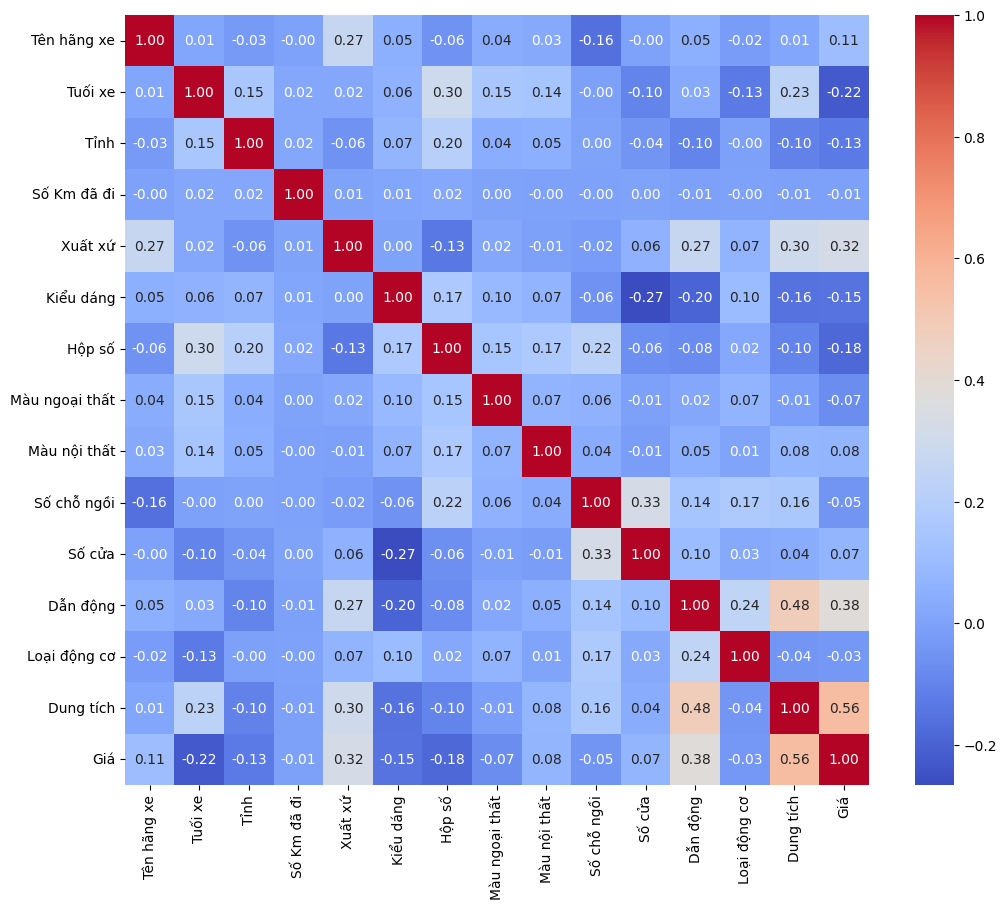

In [6]:
corr_matrix = encode_label_frequent(
    dataset, 
    columns=["Tên hãng xe", "Tỉnh", "Xuất xứ", "Kiểu dáng", "Hộp số", "Màu ngoại thất", "Màu nội thất", "Dẫn động", "Loại động cơ"]
).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

### Chia tập dữ liệu huấn luyện, kiểm thử

In [7]:
X_train, X_test, y_train, y_test = get_train_test_dataset(
    encode_label_frequent(
        dataset, 
        columns=["Tên hãng xe", "Tỉnh", "Xuất xứ", "Kiểu dáng", "Hộp số", "Màu ngoại thất", "Màu nội thất", "Dẫn động", "Loại động cơ"]
    )
)
print(len(X_train), len(X_test))
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train

20465 5117


,Tên hãng xe,Tuối xe,Tỉnh,Số Km đã đi,Xuất xứ,Kiểu dáng,Hộp số,Màu ngoại thất,Màu nội thất,Số chỗ ngồi,Số cửa,Dẫn động,Loại động cơ,Dung tích
0,0,3,0,22.0,1,0,0,0,2,5,5,0,0,1.8
1,7,4,2,28.0,1,4,0,2,0,5,5,0,0,1.2
2,7,2,0,29.0,0,0,0,1,0,7,5,0,0,1.5
3,3,4,0,60.0,1,0,0,3,0,7,5,1,1,2.0
4,1,6,0,57.0,0,0,0,0,1,5,5,2,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20460,4,9,1,80.0,0,5,0,6,1,7,5,0,0,3.3
20461,2,0,0,0.0,0,2,0,1,0,5,5,0,0,2.0
20462,6,6,18,70.0,1,3,0,9,0,5,4,3,1,2.4
20463,2,2,0,38.0,0,0,0,3,2,7,5,2,1,2.2


### Thiết kế baseline bằng mô hình Linear Regression đơn giản

Huấn luyện mô hình Linear Regression trên tập dữ liệu huấn luyện: X_train, y_train

[[1912. 2459.]
 [1584. 2950.]
 [-219.  165.]
 ...
 [1403. 1222.]
 [1205.  876.]
 [1862. 4381.]]
Mean Squared Error: 1306355.9879626746
Mean Absolute Error: 680.1869077509459
R^2 Score: 0.5075520201445868
Max Error: 11227.37597247917


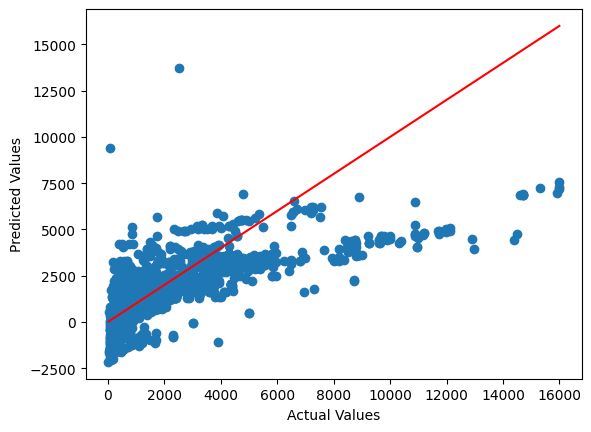

In [8]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
_ = evaluate(y_pred, y_test.values)

### Lasso Regression (L1 Regularization)

[[1913. 2459.]
 [1584. 2950.]
 [-220.  165.]
 ...
 [1403. 1222.]
 [1206.  876.]
 [1862. 4381.]]
Mean Squared Error: 1306348.1627160665
Mean Absolute Error: 680.1072401683957
R^2 Score: 0.5075549699736683
Max Error: 11224.208229174496


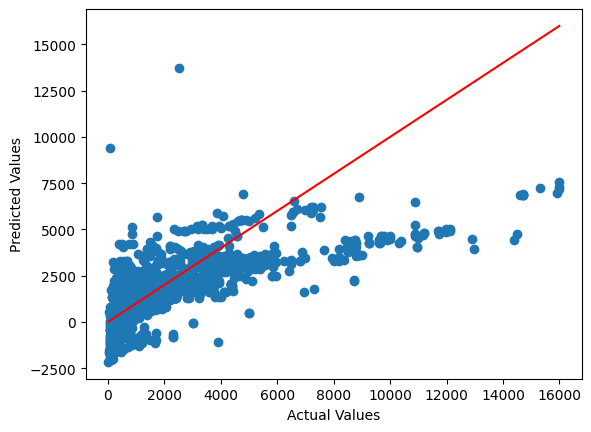

In [9]:
from sklearn.linear_model import Lasso

regressor = Lasso(alpha=0.1)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
_ = evaluate(y_pred, y_test.values)

### Ridge Regression (L2 Rugularization)

[[1912. 2459.]
 [1584. 2950.]
 [-219.  165.]
 ...
 [1403. 1222.]
 [1205.  876.]
 [1862. 4381.]]
Mean Squared Error: 1306355.8739691514
Mean Absolute Error: 680.1849393205332
R^2 Score: 0.5075520631159367
Max Error: 11227.218171740804


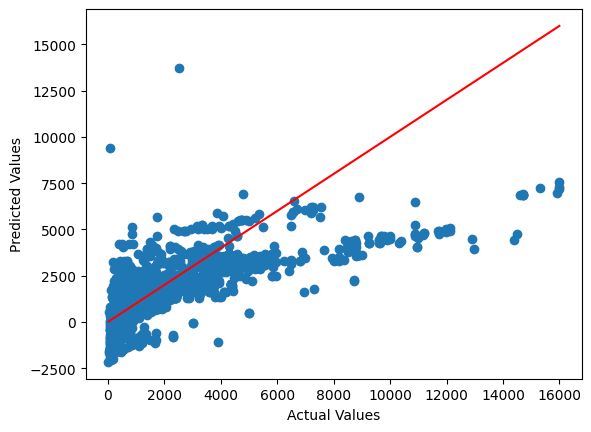

In [10]:
from sklearn.linear_model import Ridge

regressor = Ridge(alpha=0.1)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
_ = evaluate(y_pred, y_test.values)

## Decision Tree Regression

[[1814. 2459.]
 [1379. 2950.]
 [ 155.  165.]
 ...
 [1275. 1222.]
 [ 815.  876.]
 [4475. 4381.]]
Mean Squared Error: 246032.40129017574
Mean Absolute Error: 88.48048369722999
R^2 Score: 0.9072548676542025
Max Error: 23980.0


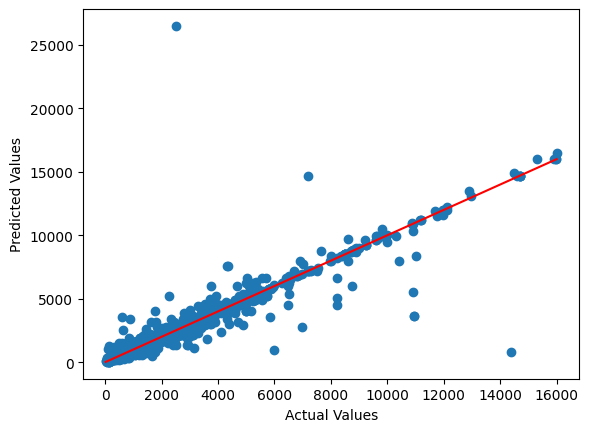

0.9987931622827303
0.9072548676542025


In [11]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

_ = evaluate(y_pred, y_test.values)
print(regressor.score(X_train, y_train))
print(regressor.score(X_test, y_test))

## Random Forest Regression

[[1841. 2459.]
 [1700. 2950.]
 [ 167.  165.]
 ...
 [1262. 1222.]
 [ 818.  876.]
 [4473. 4381.]]
Mean Squared Error: 117830.40690927625
Mean Absolute Error: 79.94135462088666
R^2 Score: 0.9555822866181309
Max Error: 13950.927857142862


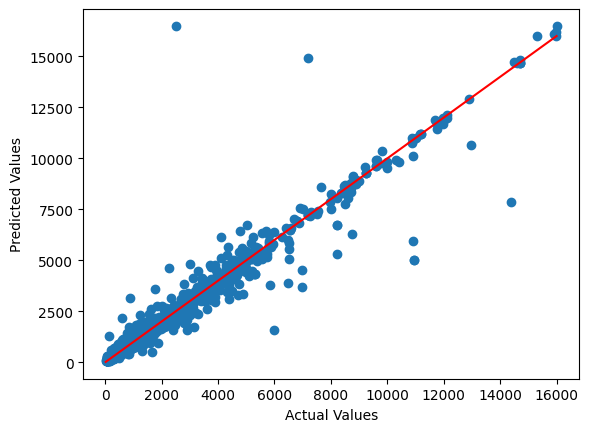

0.9948219873733831
0.9555822866181309


In [12]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

_ = evaluate(y_pred, y_test.values)
print(regressor.score(X_train, y_train))
print(regressor.score(X_test, y_test))

Tối ưu hóa Random Forest bằng GridSearch

In [13]:
# from sklearn.model_selection import GridSearchCV
# params = {
#     "criterion": ["squared_error", "friedman_mse", "poisson"],
#     "max_depth": [None, 10, 20, 50],
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 5, 15],
#     "max_features": ["sqrt", "log2", None]
# }
# regressor = RandomForestRegressor(random_state=1, n_estimators=100)

# optimizer = GridSearchCV(regressor, params, n_jobs=-1, scoring="neg_mean_squared_error", verbose=1)
# optimizer.fit(X_train.values, y_train.values)

# print(optimizer.best_params_)
# y_pred = optimizer.predict(X_test)
# _ = evaluate(y_pred, y_test.values)

## K-Nearest Neighbors (KNN)

In [14]:
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

preprocessor = make_column_transformer(
    (StandardScaler(), ['Số Km đã đi']),
    remainder='passthrough'
)

pipeline = make_pipeline(preprocessor, KNeighborsRegressor(n_neighbors=5))

pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Số Km đã đi'])])),
                ('kneighborsregressor', KNeighborsRegressor())])

[[1980. 2459.]
 [ 950. 2950.]
 [ 153.  165.]
 ...
 [1249. 1222.]
 [ 834.  876.]
 [4491. 4381.]]
Mean Squared Error: 312657.7746179402
Mean Absolute Error: 174.4717607973422
R^2 Score: 0.882139561562531
Max Error: 11652.2


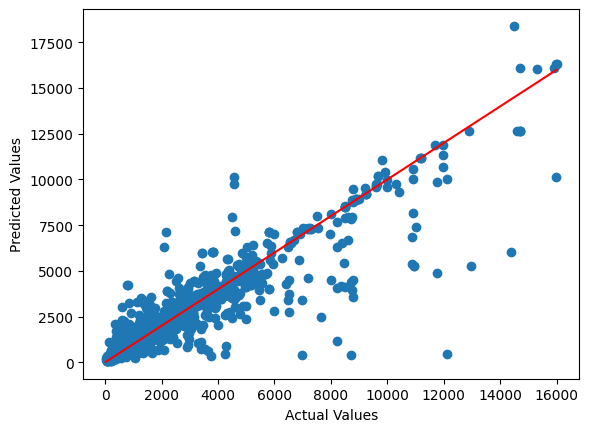

0.939341481981606
0.882139561562531


In [15]:
y_pred = pipeline.predict(X_test)

_ = evaluate(y_pred, y_test.values)

print(pipeline.score(X_train, y_train))
print(pipeline.score(X_test, y_test))

In [16]:
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import GridSearchCV

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# regressor = KNeighborsRegressor()
# params = {
#     "n_neighbors": range(1, 10),
#     "weights": ["uniform", "distance"],
#     "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
#     "p": [1, 2, 3, 5]
# }

# optimizer = GridSearchCV(regressor, params, cv=10, n_jobs=-1, verbose=2)
# optimizer.fit(scaler.fit_transform(X_train), y_train)

# print("Best Params:", optimizer.best_params_)
# y_pred = optimizer.predict(scaler.transform(X_test))
# _ = evaluate(y_pred, y_test.values)

## Support Vector Regression

[[ 747. 2459.]
 [ 726. 2950.]
 [ 497.  165.]
 ...
 [ 720. 1222.]
 [ 858.  876.]
 [ 785. 4381.]]
Mean Squared Error: 2682304.1399238487
Mean Absolute Error: 663.1577052586765
R^2 Score: -0.011129636358394812
Max Error: 15093.603558119828


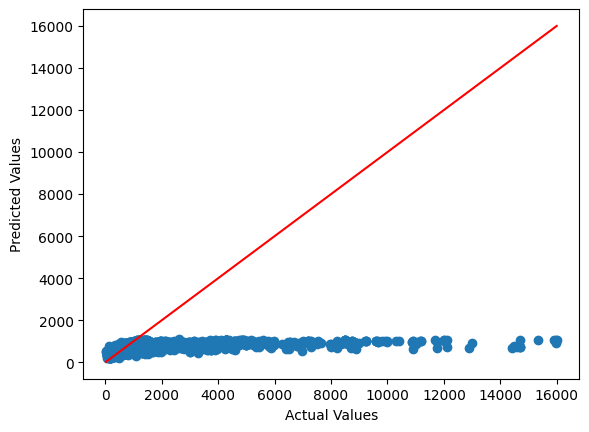

-0.0147347056339171
-0.011129636358394812


In [17]:
from sklearn.svm import SVR

preprocessor = make_column_transformer(
    (StandardScaler(), ["Số Km đã đi"]), remainder="passthrough"
)

pipeline = make_pipeline(preprocessor, SVR())

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
_ = evaluate(y_pred, y_test.values)

print(pipeline.score(X_train, y_train))
print(pipeline.score(X_test, y_test))

Tối ưu tham số SVR

In [18]:
# from sklearn.model_selection import GridSearchCV

# params = {
#     "svr__C": [100],
#     "svr__epsilon": [1],
#     "svr__gamma": ["auto"],
# }

# optimizer = GridSearchCV(pipeline, params, cv=5, scoring="neg_mean_squared_error", verbose=2, n_jobs=-1)

# optimizer.fit(X_train, y_train)

# print(optimizer.best_params_)

[[1588. 2459.]
 [2225. 2950.]
 [ 484.  165.]
 ...
 [1172. 1222.]
 [ 868.  876.]
 [2675. 4381.]]
Mean Squared Error: 1137454.2254472158
Mean Absolute Error: 311.17849371793415
R^2 Score: 0.5712217491550324
Max Error: 15094.25488362943


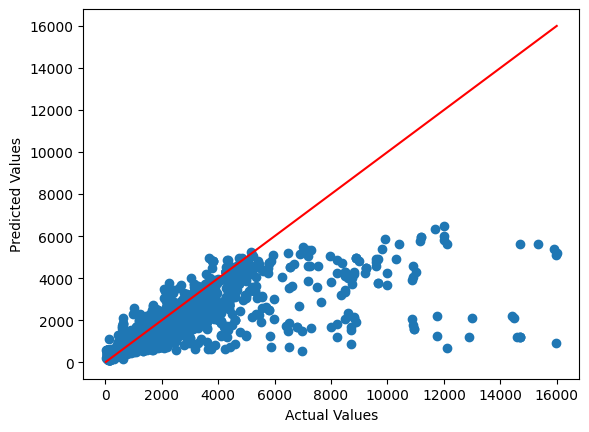

0.6058889314179055
0.5712217491550324


In [19]:
pipeline = make_pipeline(preprocessor, SVR(C=100, epsilon=1, gamma='auto'))
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

_ = evaluate(y_pred, y_test.values)

print(pipeline.score(X_train, y_train))
print(pipeline.score(X_test, y_test))

## Gradient Boosting Regression

[[2.e+03 2.e+03]
 [2.e+03 3.e+03]
 [2.e-01 2.e+02]
 ...
 [1.e+03 1.e+03]
 [9.e+02 9.e+02]
 [3.e+03 4.e+03]]
Mean Squared Error: 210688.8110241917
Mean Absolute Error: 238.63144506580778
R^2 Score: 0.9205780963818213
Max Error: 11797.23359406311


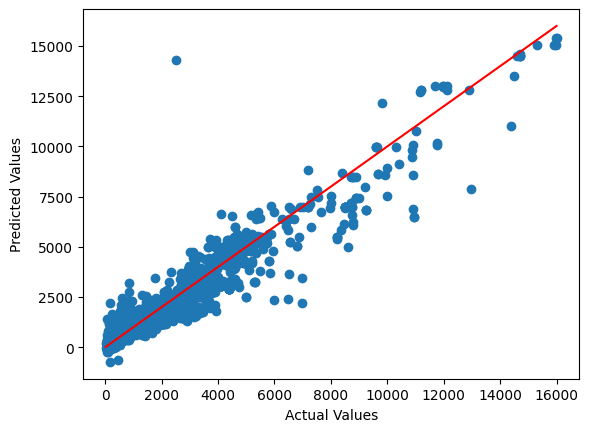

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
_ = evaluate(y_pred, y_test.values)

## Bagging

[[1832. 2459.]
 [1707. 2950.]
 [ 166.  165.]
 ...
 [1263. 1222.]
 [ 818.  876.]
 [4472. 4381.]]
Mean Squared Error: 121882.83712999252
Mean Absolute Error: 80.16954618600136
R^2 Score: 0.954054670031163
Max Error: 14451.739523809527


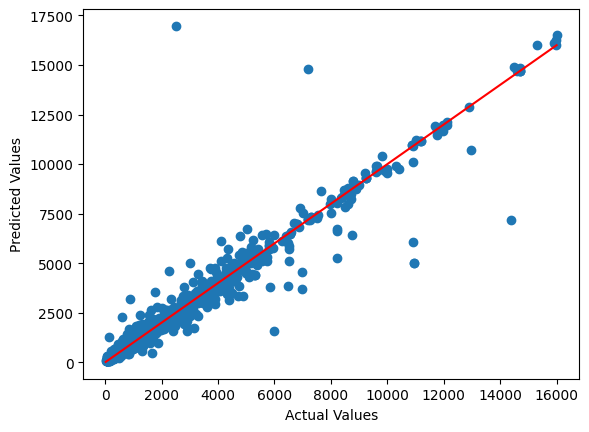

In [21]:
from sklearn.ensemble import BaggingRegressor

regressor = DecisionTreeRegressor()
bagging = BaggingRegressor(estimator=regressor, n_estimators=100, random_state=0)
bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_test)
_ = evaluate(y_pred, y_test.values)

## Bayes Regression

[[1912. 2459.]
 [1584. 2950.]
 [-220.  165.]
 ...
 [1403. 1222.]
 [1205.  876.]
 [1861. 4381.]]
Mean Squared Error: 1306346.228221142
Mean Absolute Error: 679.9972241962741
R^2 Score: 0.5075556992068379
Max Error: 11212.102151450244


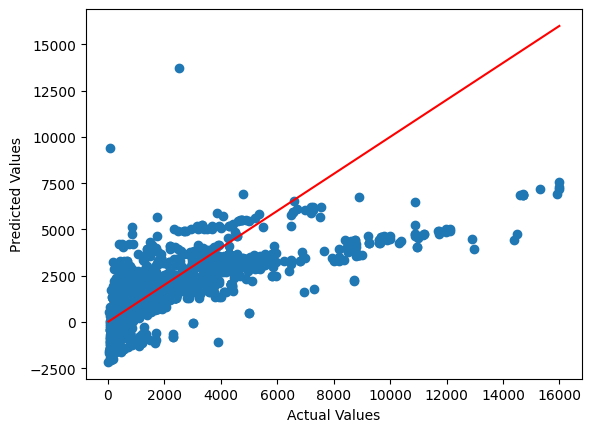

In [22]:
from sklearn.linear_model import BayesianRidge
regressor = BayesianRidge()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

_ = evaluate(y_pred, y_test.values)

## XGBoost

In [23]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

regressor = XGBRegressor(objective="reg:squarederror")
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(regressor, X_train, y_train, scoring="neg_mean_absolute_error", cv=cv, n_jobs=-1, error_score='raise')
regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

[[1801. 2459.]
 [1635. 2950.]
 [ 160.  165.]
 ...
 [1202. 1222.]
 [ 830.  876.]
 [4338. 4381.]]
Mean Squared Error: 106886.41486153963
Mean Absolute Error: 105.91033057549608
R^2 Score: 0.9597077675935476
Max Error: 10524.2392578125


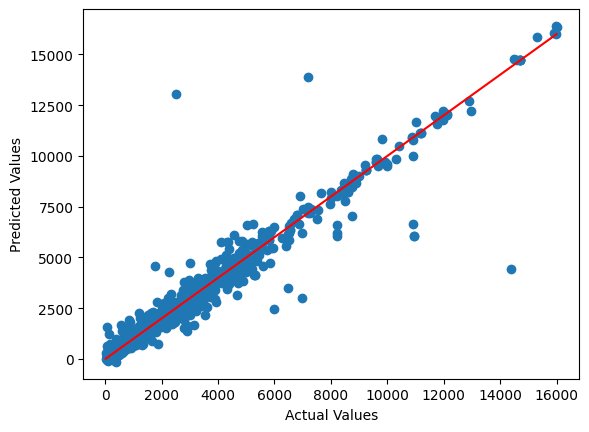

In [24]:
y_pred = regressor.predict(X_test)

_ = evaluate(y_pred, y_test.values)

## Áp dụng phương pháp giảm chiều dữ liều

### PCA: Principal Component Analysis

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=12)
pca.fit_transform(X_train)

array([[-9.e+01, -3.e+00, -5.e+00, ...,  3.e-01, -6.e-01,  5.e-01],
       [-8.e+01, -1.e+00,  2.e+00, ..., -1.e-01, -9.e-01,  9.e-02],
       [-8.e+01, -3.e+00,  2.e+00, ..., -9.e-02,  3.e-02, -3.e-01],
       ...,
       [-4.e+01,  2.e+01,  2.e+00, ..., -6.e-01,  3.e-01,  3.e-01],
       [-7.e+01, -3.e+00, -3.e+00, ..., -7.e-01,  1.e-01,  3.e-02],
       [ 5.e+01, -2.e+00,  1.e+00, ..., -7.e-01,  2.e-01, -4.e-01]])

[[3139. 2459.]
 [1970. 2950.]
 [ 261.  165.]
 ...
 [1130. 1222.]
 [ 814.  876.]
 [4470. 4381.]]
Mean Squared Error: 188330.95920546725
Mean Absolute Error: 108.72830484516217
R^2 Score: 0.9290061811179033
Max Error: 14677.182523809523


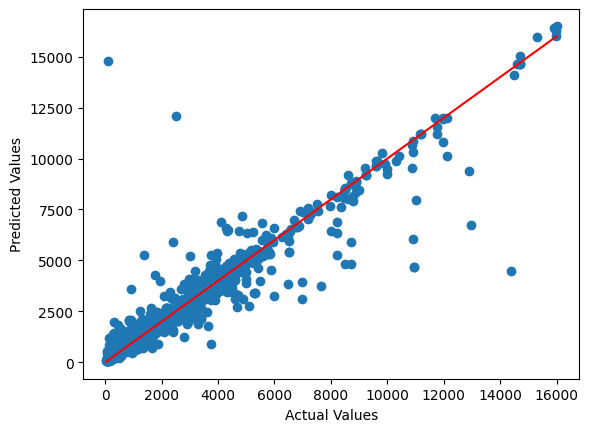

In [26]:
regressor = RandomForestRegressor()
regressor.fit(pca.fit_transform(X_train), y_train.values)
y_pred = regressor.predict(pca.transform(X_test))

_ = evaluate(y_pred, y_test.values)

### LDA: Linear Discriminant Analysis 

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=10)
lda.fit_transform(X_train, y_train)

array([[-1.,  0., -0., ..., -1.,  1., -2.],
       [ 2.,  0.,  0., ...,  2.,  1., -2.],
       [-0.,  1., -0., ..., -0.,  0.,  1.],
       ...,
       [-1., -0., -0., ...,  1., -2., -1.],
       [-2.,  2., -0., ...,  0., -0.,  1.],
       [ 2., -3.,  0., ...,  1., -1., -1.]])

[[1919. 2459.]
 [1636. 2950.]
 [ 167.  165.]
 ...
 [1206. 1222.]
 [ 820.  876.]
 [4345. 4381.]]
Mean Squared Error: 152399.96632978463
Mean Absolute Error: 102.91657880115466
R^2 Score: 0.9425508389438486
Max Error: 14466.391666666666


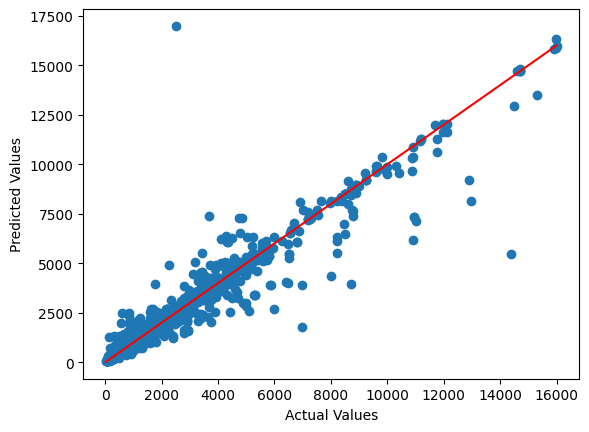

In [28]:
regressor = RandomForestRegressor()
regressor.fit(lda.fit_transform(X_train, y_train), y_train.values)
y_pred = regressor.predict(lda.transform(X_test))

_ = evaluate(y_pred, y_test.values)

## Loại bỏ outlier và huấn luyện lại 1 số mô hình mạnh

In [29]:
from scipy import stats

def remove_outliers(dataset):
    numeric_columns = ["Giá", "Số Km đã đi"]

    for col in numeric_columns:
        z_scores = stats.zscore(dataset[col])
        abs_z_scores = abs(z_scores)
        filtered_entries = abs_z_scores < 3
        dataset = dataset[filtered_entries]
    print("Kích thước dữ liệu sau khi loại bỏ outlier", dataset.shape)
    return dataset

dataset = remove_outliers(dataset)
print(dataset.shape)
dataset.head()

Kích thước dữ liệu sau khi loại bỏ outlier (25041, 15)
(25041, 15)


,Tên hãng xe,Tuối xe,Tỉnh,Số Km đã đi,Xuất xứ,Kiểu dáng,Hộp số,Màu ngoại thất,Màu nội thất,Số chỗ ngồi,Số cửa,Dẫn động,Loại động cơ,Dung tích,Giá
0,17,4,1,30.0,1,1,0,1,0,5,4,2,0,3.0,2950.0
1,17,10,0,94.0,1,1,0,3,2,5,4,0,0,2.0,560.0
2,17,8,1,50.0,1,1,0,1,0,5,4,0,0,2.0,690.0
3,17,8,0,76.0,1,2,0,3,0,5,5,2,0,2.0,699.0
4,17,8,0,90.0,1,0,0,0,1,5,5,2,0,2.0,739.0


In [30]:
X_train, X_test, y_train, y_test = get_train_test_dataset(dataset)
print(len(X_train), len(X_test))

20032 5009


[[ 580.  629.]
 [ 428.  470.]
 [ 578.  575.]
 ...
 [ 400.  425.]
 [5389. 5389.]
 [1240. 1239.]]
Mean Squared Error: 34333.41823905444
Mean Absolute Error: 67.67312935610325
R^2 Score: 0.9655981853576712
Max Error: 2684.0


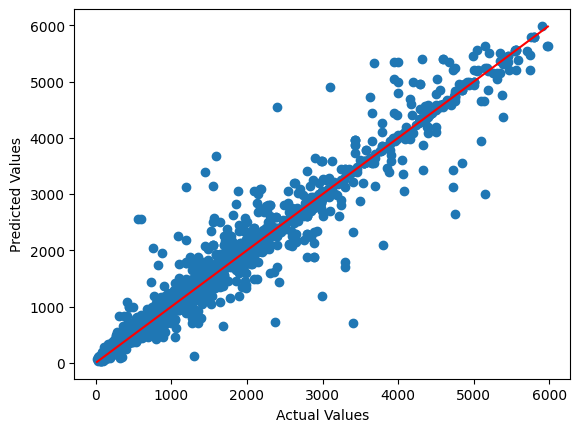

0.9984221836186102
0.9655981853576712


In [31]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

_ = evaluate(y_pred, y_test.values)
print(regressor.score(X_train, y_train))
print(regressor.score(X_test, y_test))

[[ 600.  629.]
 [ 473.  470.]
 [ 577.  575.]
 ...
 [ 416.  425.]
 [5157. 5389.]
 [1248. 1239.]]
Mean Squared Error: 24864.75111719059
Mean Absolute Error: 63.606578031198275
R^2 Score: 0.9750857152321578
Max Error: 2074.435


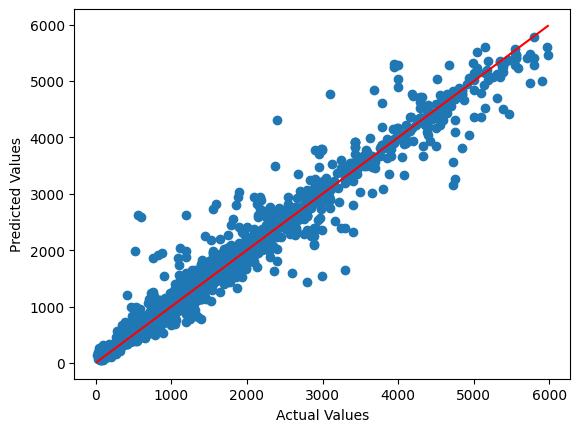

0.9953738859472056
0.9750857152321578


In [32]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

_ = evaluate(y_pred, y_test.values)
print(regressor.score(X_train, y_train))
print(regressor.score(X_test, y_test))

Dung tích         0.345714
Tuối xe           0.266318
Tên hãng xe       0.096594
Dẫn động          0.096347
Xuất xứ           0.063000
Số Km đã đi       0.035796
Kiểu dáng         0.035640
Loại động cơ      0.024897
Số chỗ ngồi       0.010483
Số cửa            0.008479
Màu nội thất      0.006940
Màu ngoại thất    0.004374
Tỉnh              0.002911
Hộp số            0.002507
dtype: float64


Text(0.5, 1.0, 'Visualizing Important Features')

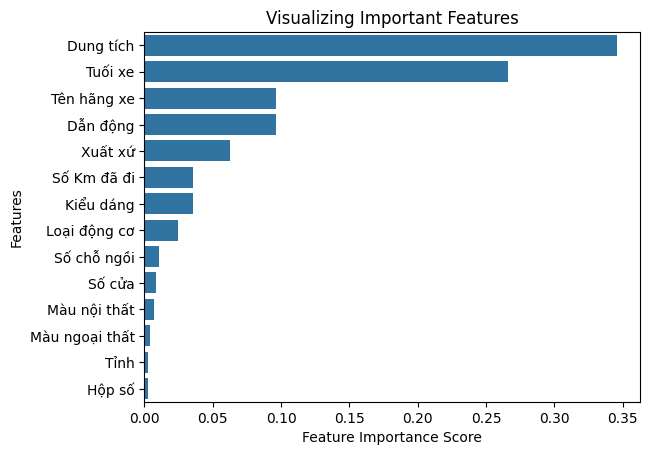

In [33]:
feature_imp = pd.Series(regressor.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_imp)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Visualizing Important Features")